# First Name EDA

Analysis of first name information, using Helvetas dataset and data from the Federal Statistical Office for [men](https://www.bfs.admin.ch/bfs/en/home/statistics/population/births-deaths/first-names-switzerland.assetdetail.13707162.html) and [women](https://www.bfs.admin.ch/bfs/en/home/statistics/population/births-deaths/first-names-switzerland.assetdetail.13707161.html) living in Switzerland in 2019 including birth year statistics.

To run this notebook, download the datasets from the FSO and save them in the folder `data/01_raw` with the names `male_names` `and female_names`


In [2]:
%reload_kedro

2020-11-01 16:50:53,628 - root - INFO - ** Kedro project Helvetas Hack4Good
2020-11-01 16:50:53,629 - root - INFO - Defined global variable `context` and `catalog`


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Helvetas data
helvetas = catalog.load("helvetas_data")
print("Helvetas dataset:\n ", helvetas.vname.count(), "entries with first name from ", len(helvetas), " total donors\n ", 
      helvetas.gescode.count(), "entries with sex from ", len(helvetas), " total donors")
df = helvetas[["adrnum", "gescode", "vname"]]

2020-11-01 16:54:55,497 - kedro.io.data_catalog - INFO - Loading data from `helvetas_data` (CSVDataSet)...
Helvetas dataset:
  320586 entries with first name from  323656  total donors
  320922 entries with sex from  323656  total donors


In [27]:
# Names data
males = catalog.load("male_names")
males.rename(columns={'First name':'vname'}, inplace=True)
females = catalog.load("female_names")
females.rename(columns={'First name':'vname'}, inplace=True)

2020-11-01 16:54:56,701 - kedro.io.data_catalog - INFO - Loading data from `male_names` (ExcelDataSet)...


/usr/local/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/usr/local/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


2020-11-01 16:54:59,973 - kedro.io.data_catalog - INFO - Loading data from `female_names` (ExcelDataSet)...


In [28]:
print("- Helvetas:\n ", df.vname.describe(), "\n\n- Male Swiss names:\n ", males.vname.describe(),  "\n\n- Female Swiss names:\n ", females.vname.describe())
n = sum(df.vname.isin(males.vname)) + sum(df.vname.isin(females.vname))
print("\nThere are ", n , "(", round(n/len(df)*100), "%) donors with names in the Swiss statistics")

- Helvetas:
  count     320586
unique     25318
top        Peter
freq        4136
Name: vname, dtype: object 

- Male Swiss names:
  count        998
unique       998
top       Maurus
freq           1
Name: vname, dtype: object 

- Female Swiss names:
  count         999
unique        999
top       Cláudia
freq            1
Name: vname, dtype: object

There are  274340 ( 85 %) donors with names in the Swiss statistics


In [29]:
# Dealing with special characters
males["vname2"] = males.vname.str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').replace(r"[^a-zA-Z\d\_]+", "")   
females["vname2"] = females.vname.str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').replace(r"[^a-zA-Z\d\_]+", "")   

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
name = df.vname.str.split(" ", expand = True)
# choose longest 
name.iloc[:,1] = name.iloc[:,1].where(name.iloc[:,1].notnull(), "")
name["vname"] = name.iloc[:,0].where(name.iloc[:,0].str.len() >= name.iloc[:,1].str.len(), name.iloc[:,1])
df["vname2"] = name.vname.str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(r"[^a-zA-Z\d\_]+", "")   


In [31]:
n = sum(df.vname2.isin(males.vname2)) + sum(helvetas.vname2.isin(females.vname2))
print("\nThere are ", n , "(", round(n/len(helvetas)*100), "%) donors with names in the Swiss statistics")
# There is an improvement, so we include this cleaning step in the pipeline


There are  281525 ( 87 %) donors with names in the Swiss statistics


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Filter names datasets with names in Helvetas dataset
female_helvetas = females[females.vname.isin(df.vname)]
male_helvetas = males[males.vname.isin(df.vname)]
# Names in female and male lists
set(female_helvetas.vname).intersection(set(male_helvetas.vname))
# We will take sex into account when joining statistics

{'Andrea',
 'Camille',
 'Claude',
 'Dominique',
 'Gabriele',
 'Kim',
 'Nicola',
 'Noa',
 'Simone',
 'Tenzin'}

In [1]:
# Entries with name information but no sex
nosex = df.vname[df.gescode.isna()]
nosex[~nosex.isna()]
# Shoud we do something with these entries?

In [223]:
# Join females and males datasets and add sex column
female_helvetas.insert(1, 'gescode', 'f')
male_helvetas.insert(1, 'gescode', 'm')
male_helvetas.insert(3, 'J_1914', '*')
male_helvetas.insert(4, 'J_1915', '*')
male_helvetas.insert(5, 'J_1916', '*')

names = pd.concat([female_helvetas, male_helvetas])
names.reset_index(drop=True, inplace=True)

In [231]:
# Data preprocessing
# Rename years columns names
j_years = names.filter(like='J_')
years = j_years.rename(columns=lambda x: int(x[2:])).columns
names.rename(columns=dict(zip(j_years, years)), inplace=True)
# Replace * with 0 values
names.replace('*', 0, inplace=True)
names.head()
years = names.filter(regex=r"[0-9]").columns
years.astype('float64') 

Float64Index([1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0, 1920.0, 1921.0,
              1922.0, 1923.0,
              ...
              2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0,
              2018.0, 2019.0],
             dtype='float64', length=106)

Text(0.5, 1.0, 'Name counts by year in Switzerland')

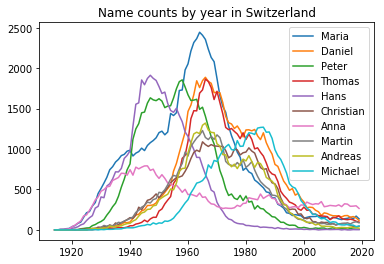

In [25]:
names.sort_values('Total', ascending=False, inplace=True)
names.reset_index(inplace=True, drop=True)
for i in range(10):
    plt.plot(years, names.loc[i, range(1914, 2020)], label=names.vname[i])
plt.legend()
plt.title("Name counts by year in Switzerland")

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Text(0.5, 1.0, 'Name counts by year of Helvetas donors')

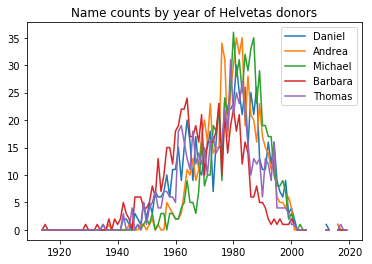

In [26]:
# Plots with name counts for Helvetas dataset
labeled = helvetas[helvetas.gebjah != 0]
gdf = labeled.groupby(['gebjah'])['vname'].value_counts().unstack(level=0, fill_value=0)
gdf["Total"] = gdf.sum(axis=1)
#gdf["vname"] = gdf.index
gdf.sort_values('Total', ascending=False, inplace=True)
gdf.reset_index(inplace=True)
for i in range(5):
    plt.plot(years, gdf.loc[i, range(1914, 2020)], label=gdf.vname[i])
plt.legend()
plt.title("Name counts by year of Helvetas donors")

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


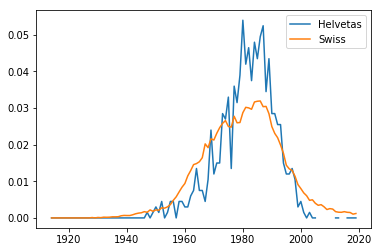

In [27]:
name = "Michael"
plt.plot(years, np.array(gdf[gdf.vname==name].loc[:, range(1914, 2020)])[0]/sum(np.array(gdf[gdf.vname==name].loc[:, range(1914, 2020)].fillna(0))[0]), label="Helvetas")
plt.plot(years, np.array(names[names.vname==name].loc[:, range(1914, 2020)])[0]/sum(np.array(names[names.vname==name].loc[:, range(1914, 2020)])[0]), label="Swiss")
plt.legend()

In [28]:
# Feature engineering
# We compute the P(age|name,sex) = # persons that year and that name and sex / # persons with that name and sex
# and take the age with maximum probability for that name as a new feature (map_year)
# and the expected age for that name (e_year = sum(P(age|name,year) * age)) as another feature
# Create map and expected year columns
names["map_year"] = names.iloc[:, 3:].idxmax(axis="columns")
names["e_year"] = (years * names.iloc[:, 3:-1]).divide(names.iloc[:, 3:-1].sum(axis=1), axis=0).sum(axis=1)

In [2]:
names.head()

In [3]:
helvetas2 = pd.merge(helvetas, names.loc[:, ["vname", "gescode", "map_year", "e_year"]], how="left")
helvetas2.head()

In [31]:
labeled2 = helvetas2.loc[(helvetas2.gebjah != 0) & (~helvetas2.map_year.isna()) & (labeled.gebjah >= 1900)]
print("MSE max_year:", mean_squared_error(labeled2.gebjah, labeled2.map_year))
print("MSE weigth_year:", mean_squared_error(labeled2.gebjah, labeled2.e_year))
mean_year = np.mean(labeled2.gebjah)
print("MSE mean_year:", mean_squared_error(labeled2.gebjah, np.ones(len(labeled2))*mean_year))

MSE max_year: 301.59241731504505
MSE weigth_year: 192.8174398757847
MSE mean_year: 267.0253495916563


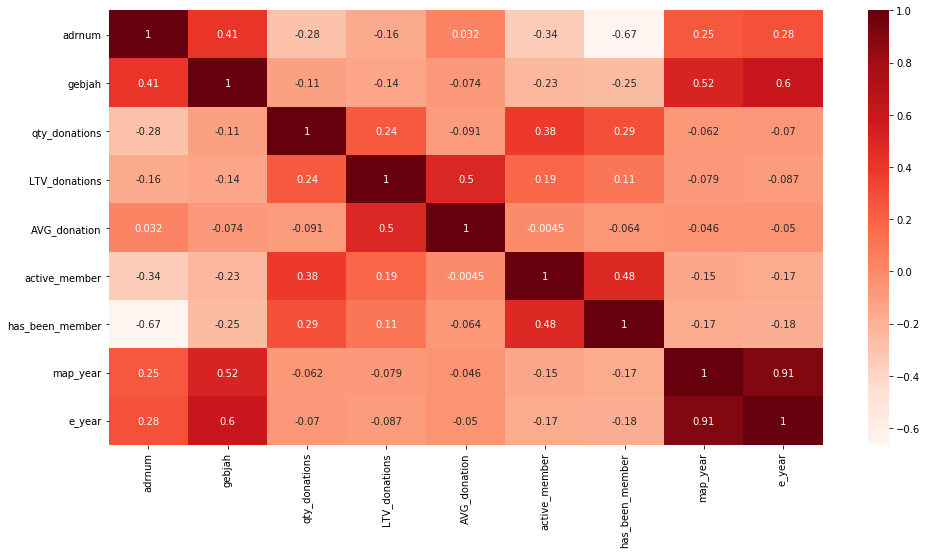

In [32]:
plt.figure(figsize=(16,8))
cor = labeled2.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [33]:
# Another approach could be to have one column for each generation, 
# with the probabilities of that name in that generation
# 
# - gen1, WiederaufbauerInnen: Birthyear before 1952
# - gen2, Babyboomer: Birthyears 1952-1966
# - gen3, Generation X: Birthyears 1967-1981
# - gen4 ,Millenials: Birthyears 1982 – 1996
# - gen5, iBrains: Birthyears 1997 - 2011
# - gen6, Gen Alpha: Birthyears 2012 - Present

names["gen1"] =  names.loc[:, range(1914, 1952)].sum(axis=1).divide(names.loc[:, range(1914, 2020)].sum(axis=1), axis=0)
names["gen2"] =  names.loc[:, range(1952, 1967)].sum(axis=1).divide(names.loc[:, range(1914, 2020)].sum(axis=1), axis=0)
names["gen3"] =  names.loc[:, range(1967, 1982)].sum(axis=1).divide(names.loc[:, range(1914, 2020)].sum(axis=1), axis=0)
names["gen4"] =  names.loc[:, range(1982, 1997)].sum(axis=1).divide(names.loc[:, range(1914, 2020)].sum(axis=1), axis=0)
names["gen5"] =  names.loc[:, range(1997, 2012)].sum(axis=1).divide(names.loc[:, range(1914, 2020)].sum(axis=1), axis=0)
#names["gen6"] =  names.loc[:, range(2012, 2020)].sum(axis=1).divide(names.loc[:, range(1914, 2020)].sum(axis=1), axis=0)

In [4]:
col_list = ["vname", "gescode", "map_year", "e_year", "gen1", "gen2", "gen3", "gen4", "gen5"]
helvetas3 = pd.merge(helvetas, names.loc[:, col_list], how="left")
labeled3 = helvetas3.loc[(helvetas3.gebjah != 0) & (~helvetas3.map_year.isna()) & (helvetas3.gebjah >= 1900)]
labeled3.head()

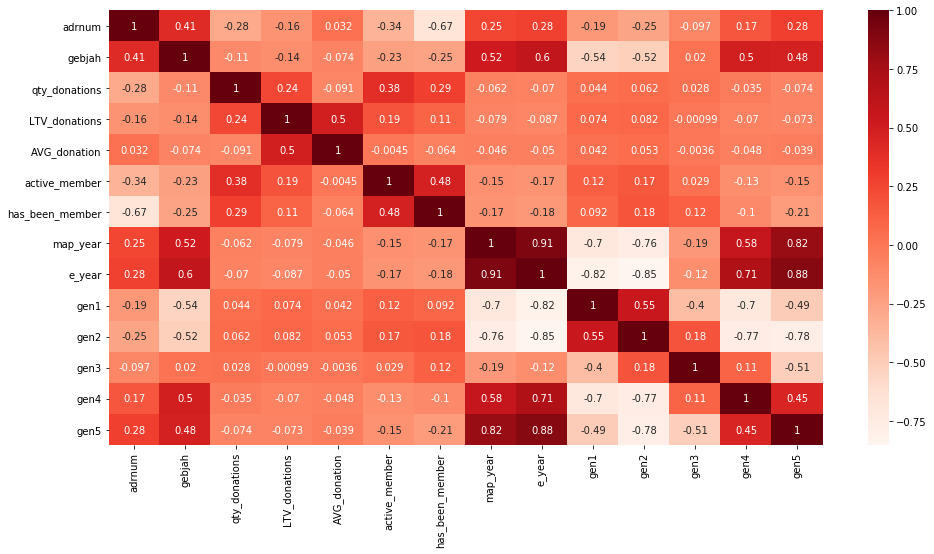

In [35]:
plt.figure(figsize=(16,8))
cor = labeled3.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

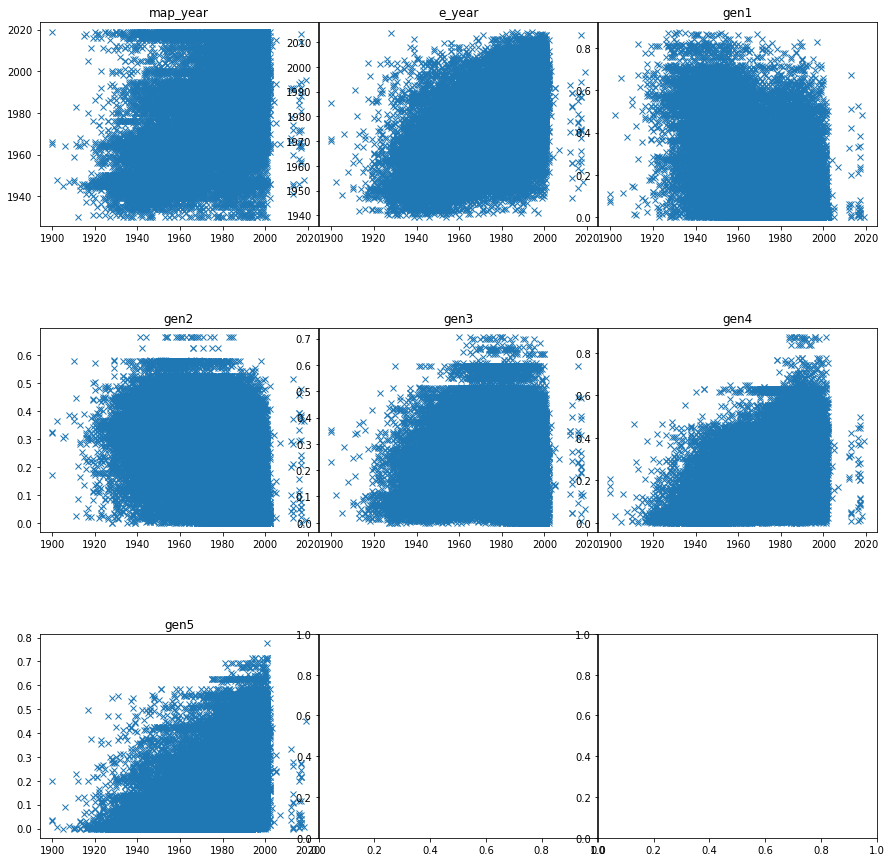

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
plot_vars = ["map_year", "e_year", "gen1", "gen2", "gen3", "gen4", "gen5"]



for i in range(7):
    axs[i].plot(labeled3.gebjah, labeled3[plot_vars[i]], 'x')
    axs[i].set_title(plot_vars[i])
    